# HEX algorithm **Kopuru Vespa Velutina Competition**

**XGBoost model**

Purpose: Predict the number of Nests in each of Biscay's 112 municipalities for the year 2020.

Output: *(WaspBusters_20210624_months_XGBoostAVGBaseHybrid.csv)*

@authors:
* mario.bejar@student.ie.edu
* pedro.geirinhas@student.ie.edu
* a.berrizbeitia@student.ie.edu
* pcasaverde@student.ie.edu

## Libraries

In [184]:
# Base packages -----------------------------------
import numpy as np
import pandas as pd

# Visualization -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)
import seaborn as sns
plt.style.use("seaborn-notebook")

# Scaling data ------------------------------------
from sklearn import preprocessing

# Grid search -------------------------------------
from sklearn.model_selection import GridSearchCV

# Confusion matrix --------------------------------
from sklearn.metrics import classification_report

# XGBoost -----------------------------------------
from xgboost import XGBRegressor
from xgboost import plot_importance

## Functions

In [185]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype(str) + HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype(str) + template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

## Get the data

In [186]:
QUEEN_train = pd.read_csv('./WBds03_QUEENtrainMONTHS.csv', sep=',')
QUEEN_predict = pd.read_csv('./WBds03_QUEENpredictMONTHS.csv', sep=',')

clustersMario = pd.read_csv("./WBds_CLUSTERSnests.csv")

template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

In [187]:
#QUEEN_predict.isnull().sum()

In [188]:
QUEEN_train.shape

(2688, 43)

In [189]:
QUEEN_predict.shape

(1344, 43)

### Add in more Clusters (nest amount clusters)

In [190]:
QUEEN_train = pd.merge(QUEEN_train, clustersMario, how = 'left', on = ['municip_code', 'municip_name'])
QUEEN_predict = pd.merge(QUEEN_predict, clustersMario, how = 'left', on = ['municip_code', 'municip_name'])

In [191]:
QUEEN_train.fillna(4, inplace=True)
QUEEN_predict.fillna(4, inplace=True)

In [192]:
QUEEN_train.shape

(2688, 44)

In [193]:
QUEEN_predict.shape

(1344, 44)

In [194]:
QUEEN_predict.Cluster.value_counts()

0.0    792
2.0    492
1.0     48
4.0     12
Name: Cluster, dtype: int64

## Get hyperparameters with GridsearchCV iterating on 2018's features (i.e. 2019's nests) as the test year
And training the model with 2017's features (i.e. 2018's nests as labels)

In [195]:
# The target variable
hyper_y_train = QUEEN_train.loc[QUEEN_train.year_offset.isin([2017]), ['municip_code', 'year_offset', 'month', 'NESTS']]
hyper_y_train = hyper_y_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyper_y_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

hyper_y_test = QUEEN_train.loc[QUEEN_train.year_offset.isin([2018]), ['municip_code', 'year_offset', 'month', 'NESTS']]
hyper_y_test = hyper_y_test.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyper_y_test.set_index(['year_offset', 'month', 'municip_code'], inplace=True)


# The features matrix
hyperXtrain = QUEEN_train.loc[QUEEN_train.year_offset.isin([2017]), :].drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
hyperXtrain = hyperXtrain.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyperXtrain.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

hyperXtest = QUEEN_train.loc[QUEEN_train.year_offset.isin([2018]), :].drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
hyperXtest = hyperXtest.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyperXtest.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

In [196]:
xgb1 = XGBRegressor(random_state=23)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
             'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(hyperXtrain, hyper_y_train)

print(xgb_grid.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[18:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


-0.8732560531236078


In [197]:
print(xgb_grid.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [198]:
#y_xgb_grid = xgb_grid.best_estimator_.predict(hyperXtest)

## Prediction time!

### 1. Choose the model class

In [199]:
XGBRegressor

xgboost.sklearn.XGBRegressor

### 2. Instantiate the model

In [200]:
xgb = xgb_grid.best_estimator_

### 3. Prepare Feature Matrixes and Target Vectors

In [201]:
# The target variable
y_train = QUEEN_train.loc[:, ['municip_code', 'year_offset', 'month', 'NESTS']]
#y_train = y_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
y_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

y_predict = QUEEN_predict.loc[:, ['municip_code', 'year_offset', 'month', 'NESTS']]
#y_predict = y_predict.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
y_predict.set_index(['year_offset', 'month', 'municip_code'], inplace=True) # this dataframe is full of zeroes

# The features matrix
X_train = QUEEN_train.drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
#X_train = X_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
X_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

X_predict = QUEEN_predict.drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
#X_predict = X_predict.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
X_predict.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

In [202]:
X_train.shape

(2688, 37)

In [203]:
y_train.shape

(2688, 1)

In [204]:
X_predict.shape

(1344, 37)

In [205]:
# Bear in mind this is not a real dataset! Just a placeholder because these labels are all zeroes. 
# Only the competition organizers know this vector's real values.

y_predict.shape

(1344, 1)

### 4. Fit the model to the training data sets

#### But first, scale a copy of the training dataset to get Feature Importances

In [206]:
X = X_train.copy()
y = y_train.copy()
scalators = X.columns
X[scalators] = preprocessing.minmax_scale(X[scalators])

In [207]:
# define the model
model_fi = XGBRegressor(random_state=23)

# fit the model
model_fi.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=23,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

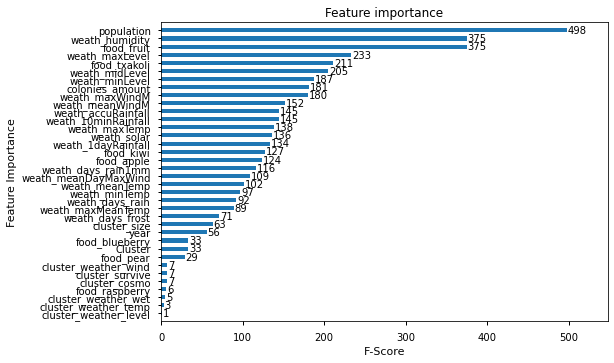

In [208]:
# get importance
importance = model_fi.feature_importances_

# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plot_importance(model_fi, height=0.5, xlabel="F-Score", ylabel="Feature Importance", grid=False)
plt.show()

#### Now, do fit the model but only with the relevant features

In [209]:
X_train = X_train.loc[:, ['population', 'weath_humidity', 'food_fruit', 'weath_maxLevel', 'food_txakoli', 'weath_midLevel', 'weath_minLevel', 'colonies_amount', 'weath_maxWindM',\
                          'weath_meanWindM', 'weath_accuRainfall', 'weath_10minRainfall', 'food_kiwi', 'food_apple', 'weath_days_rain1mm', 'weath_meanDayMaxWind', 'weath_meanTemp']]

X_predict = X_predict.loc[:, ['population', 'weath_humidity', 'food_fruit', 'weath_maxLevel', 'food_txakoli', 'weath_midLevel', 'weath_minLevel', 'colonies_amount', 'weath_maxWindM',\
                              'weath_meanWindM', 'weath_accuRainfall', 'weath_10minRainfall', 'food_kiwi', 'food_apple', 'weath_days_rain1mm', 'weath_meanDayMaxWind', 'weath_meanTemp']]

In [210]:
xgb.fit(X_train, y_train)

[18:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=23, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

### 5. Predict the labels for new data

In [211]:
y_predict = xgb.predict(X_predict)

In [212]:
y_predict.shape

(1344,)

In [213]:
QUEEN_predict['NESTS'] = y_predict

In [214]:
QUEEN_predict.NESTS.sum()

2904.2285

In [215]:
QUEEN_predict.NESTS[QUEEN_predict.NESTS < 0] = 0

<ipython-input-215-ef4b3a26f94e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QUEEN_predict.NESTS[QUEEN_predict.NESTS < 0] = 0


In [216]:
QUEEN_predict.NESTS.sum()

2909.1338

In [218]:
placeholder2018 = QUEEN_train.loc[QUEEN_train.year_offset.isin([2017]), ['municip_code', 'month', 'NESTS']]
placeholder2018.columns = ['municip_code', 'month', 'NESTS2018']

placeholder2019 = QUEEN_train.loc[QUEEN_train.year_offset.isin([2018]), ['municip_code', 'month', 'NESTS']]
placeholder2019.columns = ['municip_code', 'month', 'NESTS2019']

placeholder = pd.merge(placeholder2019, placeholder2018, how='outer', on=['municip_code', 'month'])
placeholder = pd.merge(placeholder, QUEEN_predict.loc[:, ['municip_code', 'month', 'NESTS']], how='outer', on=['municip_code', 'month'])
#placeholder

In [219]:
QUEEN_predict['NESTS'] = (placeholder.NESTS2019 * 0.5 + placeholder.NESTS2018 * 0.5) * 0.5 + placeholder.NESTS * 0.5
QUEEN_predict.NESTS.sum()

2965.066885260865

In [217]:
# export the dataset with the monthly data for viz purposes:

#QUEEN_predict.to_csv('WBds05_2020prediction_monthly.csv', index=False)

## Prepare the dataset for submission

In [220]:
HEX = QUEEN_predict.loc[:,['municip_code', 'municip_name', 'NESTS']].groupby(by=['municip_code', 'municip_name'], as_index=False).sum()

## Hard encode Bilbao 48020 to zero

In [221]:
HEX.loc[HEX.municip_code.isin([48020]), 'NESTS'] = 0

In [222]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051, 48020]), :]

,municip_code,municip_name,NESTS
19,48020,Bilbao,0.000000
21,48022,Karrantza Harana/Valle de Carranza,15.608224
50,48051,Lanestosa,3.071295
70,48071,Muskiz,22.019386
73,48074,Urduña/Orduña,11.343171
87,48088,Ubide,9.656558


In [223]:
HEX.columns = ["CODIGO MUNICIPIO", "NOMBRE MUNICIPIO", "NIDOS 2020"] # change column names to Spanish (Competition template)

In [224]:
check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2925


'All Municipality Names and Codes to be submitted match the Template'

## Hard encode municipalities 48022, 48071, 48088, 48074, and 48051

In [225]:
HEX.columns = ['municip_code', 'municip_name', 'NESTS'] # change column names to Spanish (Competition template)

In [226]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051]), 'NESTS'] = [0,0,1,0,1]

In [227]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051, 48020]), :]

,municip_code,municip_name,NESTS
19,48020,Bilbao,0.0
21,48022,Karrantza Harana/Valle de Carranza,0.0
50,48051,Lanestosa,0.0
70,48071,Muskiz,1.0
73,48074,Urduña/Orduña,0.0
87,48088,Ubide,1.0


In [228]:
HEX.columns = ["CODIGO MUNICIPIO", "NOMBRE MUNICIPIO", "NIDOS 2020"] # change column names to Spanish (Competition template)

In [229]:
check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2865


'All Municipality Names and Codes to be submitted match the Template'

### Export dataset for submission

In [230]:
HEX.to_csv('WaspBusters_20210624_months_XGBoostAVGBaseHybrid.csv', index=False)